## exercise agent

**overview:**

演示了如何创建一个基于语言模型的锻炼计划应用程序，目标是为用户指定合理的锻炼计划。支持从文件读取，并由三个agents进行合理分工。该应用程序使用 LangChain，结构化工具和agents的组合来有效地处理输入文本。

**motivation**

健身计划的合理性对于用户来说至关重要，但是定制化的建议一般需要经验丰富的教练以及专业的知识，这对于普通用户来说很困难。通过请求大语言模型来对用户的锻炼行为进行分析并指定合理的计划为用户带来了极大的便利。

**Key Components:**

- 支持本地存储：从本地读取用户行为数据
- 分析多元化：从行为数据以及定量指标分析并指定计划
- 大语言模型：大语言模型制定计划，自我思考进行建议和修改，通过路由决定是否继续。
- 结构化输出：输出具体的计划以及计划的打分。

### **Method Details**

`exer_analyze_behavior_node` ：接受用户设定的目标，并从文件中读取分析用户的锻炼行为，计算相关的指标，将summary传递给`exer_plan_node` 。

`exer_plan_node`：根据分析的行为和指标结果，由大语言模型指定下一天的锻炼计划。

`insight_generation_node`：根据历史的的行为和指标结果，以及下一天的锻炼计划，给出适当的建议以及为这个建议打分。

`router` ：路由END和`exer_plan_node` ，根据insight以及score，决定这个计划是否被接受，如果不被接受，则根据insight重新制定计划。

### Conclusion



In [1]:
from datetime import datetime, timedelta
import os
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.chat_models import ChatZhipuAI
from IPython.display import Image, display, Markdown, HTML
from dotenv import load_dotenv
from langgraph.graph import END
import numpy as np

import logging
import pandas as pd
from typing import Annotated, Any, Dict, TypedDict, List, Union
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph, START,END

load_dotenv(override=True)

True

In [2]:
llm = ChatZhipuAI(temperature=0.5,model="glm-4-flash")
os.environ["HTTP_PROXY"] = "http://127.0.0.1:1082"
os.environ["HTTPs_PROXY"] = "http://127.0.0.1:1082"

In [3]:
EXERCISE_TASK = ["run", "cycle", "yoga", "stretch", "swim", "hike", "dance", "pilates", "boxing", "weightlifting"]
EXERCISE_CALORIES = {
    "run": 100,
    "cycle": 80,
    "yoga": 50,
    "stretch": 30,
    "swim": 120,
    "hike": 90,
    "dance": 70,
    "pilates": 60,
    "boxing": 100,
    "weightlifting": 80
}

In [4]:
class Plan(BaseModel):
    tasks: List[str]
    duration: List[int]
    intensity: List[int]

class Insight(BaseModel):
    content: str
    score: int 

    
class AgentState(TypedDict):
    goal: str
    behavior_summary: Dict[str, Any]
    metrics_summary: Dict[str, Any]
    plan: Union[Plan, None]
    insights: Union[Insight, None]
    schedule: Dict[str, Any]
    history_info: Dict[str, Any]
    max_iteration: int
    iteration_number: int
    insight_scores_iterations:list[int]

In [5]:
def read_behavior_history(file_path: str):
    data = pd.read_csv(file_path)
    return data

# 计算单天的指标
def calculate_daily_metrics(durations, intensities, calories):
    # 运动负荷指数 (ELI)  反映用户每日运动总负荷，帮助评估运动量是否达标。
    eli = sum(d * i for d, i in zip(durations, intensities))
    # 心血管效益评分 (CBS)， 反映用户日常训练中有氧运动的比例，评估心血管健康的锻炼效果。
    cbs = (sum(d * i for d, i in zip(durations, intensities)) / sum(durations)) * 100 if sum(durations) > 0 else 0
    # 卡路里效率 (CE)， 衡量用户在单位时间内的卡路里消耗，反映锻炼效率。
    ce = sum(calories) / sum(durations) if sum(durations) > 0 else 0
    # 强度一致性系数 (ICF)， 衡量用户锻炼强度的波动性，数值越接近 1 表示强度分配越稳定。
    icf = 1 - (np.std(intensities) / np.mean(intensities)) if len(intensities) > 1 else 1
    return {"ELI": eli, "CBS": cbs, "CE": ce, "ICF": icf}

# 归一化函数
def normalize_daily_metrics(all_metrics):
    # 找到每个指标的最大值和最小值
    # max_values = {key: max(metrics[key] for metrics in all_metrics) for key in all_metrics[0].keys()}
    # min_values = {key: min(metrics[key] for metrics in all_metrics) for key in all_metrics[0].keys()}
    # 对每个指标的每天值进行归一化
    # normalized = {key: [] for key in all_metrics[0].keys()}
    normalized = {key: [] for key in all_metrics[0].keys()}
    for metrics in all_metrics:
        for key, value in metrics.items():
            # 不需要进行归一化
            # normalized_value = (value - min_values[key]) / (max_values[key] - min_values[key]) if max_values[key] != min_values[key] else 0
            normalized[key].append(round(value, 3))
    return normalized

# 计算几天的指标
def calculate_metrics(data):
    daily_metrics = [
        calculate_daily_metrics(
            durations=data["duration_list"][i],
            intensities=data["intensity_list"][i],
            calories=data["calories_list"][i],
        )
        for i in range(len(data["duration_list"]))
    ]
    normalized_daily_metrics = normalize_daily_metrics(daily_metrics)
    return normalized_daily_metrics


def exer_analyze_behavior_node(state: AgentState):
    """
    Analyze the behavior history of the user and return a summary of the last week
    """
    history_info = state["history_info"] 
    data = read_behavior_history(history_info['file_path'])
    end_data = history_info['end_data'] if 'end_data' in history_info else None
    if end_data is None:
        end_data = pd.Timestamp.now()  - pd.Timedelta(days=1)
    start_data = end_data - pd.Timedelta(days=8)
    # 时间从昨天开始算，往前推7天
    # last_week = data[data['date'] >= (pd.Timestamp.now() - pd.Timedelta(days=7))]
    last_week = data[(data['date'] >= start_data.strftime("%Y-%m-%d")) & (data['date'] <= end_data.strftime("%Y-%m-%d"))]
    task_counts = {}
    for tasks in last_week["tasks"]:
        for task in eval(tasks):
            if task in task_counts:
                task_counts[task] += 1
            else:
                task_counts[task] = 1
    task_counts_each_day = []
    task_each_day = []
    for tasks in last_week["tasks"]:
        task_counts_each_day.append(len(eval(tasks)))
        task_each_day.append(eval(tasks))

    duration_list = [eval(duration) for duration in last_week['duration'].tolist()]
    intensity_list = [eval(intensity) for intensity in last_week['intensity'].tolist()]
    calories_list = [eval(calories) for calories in last_week['calories'].tolist()]

    behavior_summary = {
        "sessions": task_counts,
        "sessions_each_day": task_counts_each_day,
        "task_list": task_each_day,
        "duration_list": duration_list,
        "intensity_list": intensity_list,
        "calories_list": calories_list,
        "mood_list": [mood for mood in last_week['mood']],
        "sleep_list": [sleep for sleep in last_week['sleep']]
    }
    # 根据用户的行为历史，生成用户运动指数
    metrics = calculate_metrics(behavior_summary)
    return {"behavior_summary": behavior_summary, "metrics_summary": metrics}

def exer_plan_node(state: AgentState):
    """
    Plan the exercise routine based on the user's behavior history
    """
    
    behavior_summary = state['behavior_summary']
    metrics_summary = state['metrics_summary']
    goal = state["goal"] if "goal" in state else ""
    # 根据历史信息，以及用户运动指数 指定第二天锻炼计划
    prompt = f"""
        You are an expert Fitness coach and you need help to achieve: {goal}
        1. give you user's historical behavioral data {behavior_summary} and metrics {metrics_summary}.
        2. Develop a reasonable exercise plan for one day, choose the exercise tasks from {EXERCISE_TASK} and set the duration(minutes) and intensity(0~1) of each task.
        3. your should only output the tasks: list of 'tasks', duration: list of their corresponding duration and intensity: list of 'intensity, **do no return other content**.
        """

    # 生成计划
    # structure_llm = llm.with_structured_output(Plan)
    # plan: Plan = structure_llm.invoke(prompt)
    output = llm.invoke(prompt)

    # example: "tasks: ['run', 'cycle', 'yoga', 'stretch']\nduration: [45, 30, 20, 15]\nintensity: [0.7, 0.6, 0.5, 0.4]""
    plan = {}
    lines = output.content.split('\n')
    for line in lines:
        if line.startswith("tasks:"):
            plan["tasks"] = eval(line.split("tasks:")[1].strip())
        elif line.startswith("duration:"):
            plan["duration"] = eval(line.split("duration:")[1].strip())
        elif line.startswith("intensity:"):
            plan["intensity"] = eval(line.split("intensity:")[1].strip())
            
    return {"plan": plan}
    




def insight_generation_node(state: AgentState):
    """
    Generate insights for the user based on the analysis and risk assessment
    """
   
    behavior_summary = state["behavior_summary"]
    metrics_summary = state["metrics_summary"]
    insight_scores_iterations = state["insight_scores_iterations"] if "insight_scores_iterations" in state else []
    plan = state["plan"]
    goal = state["goal"] if "goal" in state else ""
    prompt = f"""
    You are an expert Fitness coach responsible for generating actionable insights to enhance the user's exercise routine and help them achieve: {goal}
        1. **Analysis the user's historical data:**
            identify the most effective interventions based on the user's historical behavioral data {behavior_summary}, metrics {metrics_summary} and the next day exercise plan {plan}.
        2. ** Recommend Enhancements:**
            Give insight to exercise plan and Rate your current plan from 1 to 10.
        3. you should only output the insight: str and score: int, **do no return other content**.

    """

    # structure_llm = llm.with_structured_output(Insight)
    # insight: Insight = structure_llm.invoke(prompt)
    output = llm.invoke(prompt)
    lines = output.content.split('\n')
    insight = {}
    for line in lines:
        if line.startswith("Insight:") or line.startswith("insight:"):
            insight_content = line.split(":")[1].strip()
            insight["content"] = insight_content
        elif line.startswith("Score:") or line.startswith("score:"):
            score = int(line.split(":")[1].strip())
            insight["score"] = score if isinstance(score, int) else 9

    insight = Insight(**insight)
    insight_scores_iterations.append(insight.score)
    iteration_number = state["iteration_number"] + 1
    return {"insights": insight, "insight_scores_iterations": insight_scores_iterations, "iteration_number": iteration_number}

def router(state: AgentState):
    """
    Router function to route the conversation based on the user's input
    """
    
    max_iteration = state["max_iteration"]
    iteration_number = state["iteration_number"]
    state["iteration_number"] += 1

    if iteration_number < max_iteration:
        if len(state["insight_scores_iterations"])>1:
            if state["insight_scores_iterations"][-1] < state["insight_scores_iterations"][0]:
                return END
            else:
                return "exercise_plan"
        else:
            return "exercise_plan"
    else:
        return END

In [6]:
# Define the new workflow
logger = logging.getLogger(__name__)
workflow = StateGraph(AgentState)
workflow.add_node("exercise_history_analyze", exer_analyze_behavior_node)
workflow.add_node("exercise_plan", exer_plan_node)
workflow.add_node("insight_generator", insight_generation_node)

workflow.set_entry_point("exercise_history_analyze")
workflow.add_edge("exercise_history_analyze", "exercise_plan")
workflow.add_edge("exercise_plan", "insight_generator")
# workflow.add_edge("insight_generator", END)
workflow.add_conditional_edges("insight_generator", router, ["exercise_plan", END])

# set memoty saver
memory = MemorySaver()
graph_plan = workflow.compile(checkpointer=memory)

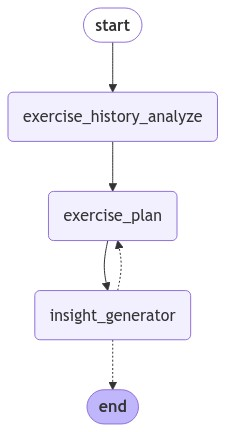

In [7]:
display(Image(graph_plan.get_graph(xray=1).draw_mermaid_png()))

In [8]:
state_input = {
        "goal": "lose weight",
        "history_info": {
            "file_path": "/data/sydong/code/agent/project/src/data/exer_data/behavior_history.csv",
            "end_date": datetime.now() - timedelta(days=1),
        },
        "max_iteration": 3,
        "iteration_number":0
    }
# state = AgentState(data=state_input)
logger.info("Starting the workflow")
config = {"configurable": {"thread_id": "1"}}
for event in graph_plan.stream(state_input, config, stream_mode=["updates"]):
    "Print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")

final_state = graph_plan.get_state(config).values
plan = final_state["plan"]
insights = final_state["insights"]
print(f"Next day exercise plan: {plan}")
print("Next day exercise insight: ", insights.content)
print("Next day exercise score : ", insights.score)

Current node: exercise_history_analyze
Current node: exercise_plan
Current node: insight_generator
Current node: exercise_plan
Current node: insight_generator
Current node: exercise_plan
Current node: insight_generator
Next day exercise plan: {'tasks': ['run', 'cycle', 'yoga', 'stretch'], 'duration': [45, 30, 20, 15], 'intensity': [0.6, 0.7, 0.5, 0.4]}
Next day exercise insight:  The user has a consistent exercise routine with a mix of activities, but the intensity seems to be on the lower side. Increasing the intensity of the workouts, particularly the running and cycling sessions, could potentially enhance calorie burn and weight loss. Additionally, incorporating more challenging yoga and stretching routines might improve flexibility and muscle tone.
Next day exercise score :  7
